---
title: 'Palmer Penguins'
author: 'Andre Xiao'
date: '2024-02-21'
image: "image.png"
description: "Predicting penguin species from the Palmer Archipelago."
format: html
number-sections: true
code-annotations: hover
---

![Image source: \@allisonhorst](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)

## Abstract

This data set contains physiological measurements and species labels for several populations of Adelie, Chinstrap, and Gentoo penguins in the Palmer Archipelago, Antarctica. This study attempts to find three features (two quantitative and one qualitative) that will be able to predict the penguins' species with 100% testing accuracy. To do this, I experiment with `scikit-learn's` logistic regression, support vector machine, random forest classifier, and decision tree classifier models. In the end, the logistic regression model was able to predict the penguins' species with 100% testing accuracy.

*The Palmer Penguins data was originally collected by `@gormanEcologicalSexualDimorphism2014` and was nicely packaged and released for use in the data science community by `@horstAllisonhorstPalmerpenguinsV02020`.*

## Importing Data
First, let's import the data from [here](https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv), simplify the penguins' species name, and look at the first five rows of data.

In [53]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)
train['Species'] = train['Species'].str.split().str.get(0)
train.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0809,31,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N63A1,Yes,11/24/08,40.9,16.6,187.0,3200.0,FEMALE,9.08458,-24.54903,NaN
1,PAL0809,41,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N74A1,Yes,11/24/08,49.0,19.5,210.0,3950.0,MALE,9.53262,-24.66867,NaN
2,PAL0708,4,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,11/27/07,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN
3,PAL0708,15,Gentoo,Anvers,Biscoe,"Adult, 1 Egg Stage",N38A1,Yes,12/3/07,45.8,14.6,210.0,4200.0,FEMALE,7.79958,-25.62618,NaN
4,PAL0809,34,Chinstrap,Anvers,Dream,"Adult, 1 Egg Stage",N65A2,Yes,11/24/08,51.0,18.8,203.0,4100.0,MALE,9.23196,-24.17282,NaN


After importing the data, we need to clean our data and prepare our qualitative data. The below function uses one-hot encoding to turn the qualitative data into `0` and `1` columns. In this case, the values will be `True` and `False`. Additionally, the function also splits away our $y$ variable which is stored in the variable `y_train`.

In [54]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1) # <1> 
  df = df[df["Sex"] != "."] # <2> 
  df = df.dropna() # <3> 
  y = le.transform(df["Species"]) # <4> 
  df = df.drop(["Species"], axis = 1) # <5>
  df = pd.get_dummies(df) # <6> 
  return df, y

X_train, y_train = prepare_data(train)
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


1. Drop unwanted columns.
2. Remove `.` from SEX data.
3. drop `NaNs`.
4. Sets species as $y$ data.
5. Drops species from $x$ data.
6. One-hot encoding, `0-1` columns.

## Visualization of a Couple Features

Let's visualize some potential features using two scatterplots and a summary table. In the two graphs below, I build up on these [notes](https://www.philchodrow.prof/ml-notes/chapters/02-black-box-classification.html). In these notes, we discovered that `Culmen Length (mm)` and `Culmen Depth (mm)` are strong features to use to classify species type. In this study, I will be adding a qualitative data to help improve the test accuracy of the model. 

### Figures
The figure on the left uses the `Island` column as the qualitative feature and the figure on the right uses the `Sex` column as the qualitative feature.

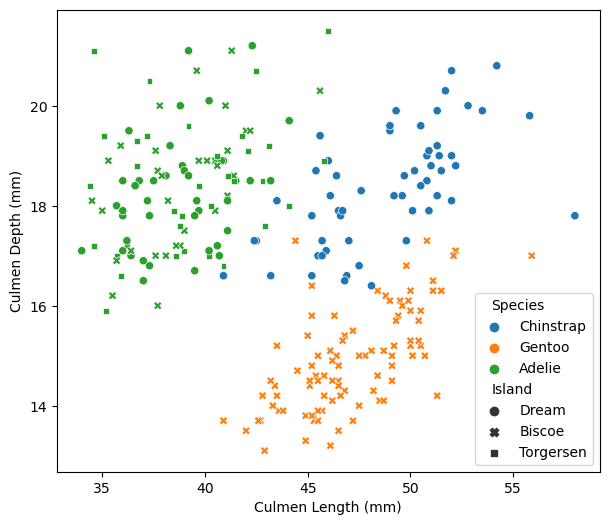

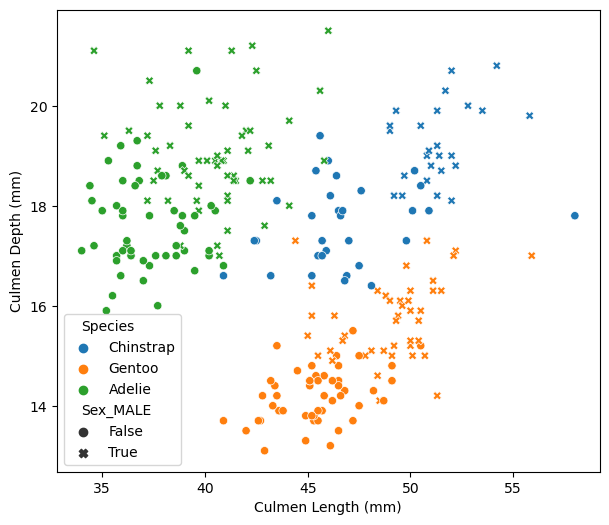

In [55]:
#| code-fold: true
#| fig-cap: Compares Species by culmen length, culmen depth, island and sex.
#| fig-subcap:
#|  - 'Species by Culmen Length, Culmen Depth, and Island.'
#|  - 'Species by Culmen Length, Culmen Depth, and Sex.'
#| layout-ncol: 2
#| label: fig-species

import seaborn as sns
from matplotlib import pyplot as plt


fig, ax = plt.subplots(1, 1, figsize = (7, 6))
fig1, ax1 = plt.subplots(1, 1, figsize = (7, 6))

p1 = sns.scatterplot(X_train, x = 'Culmen Length (mm)', y = 'Culmen Depth (mm)', style = train['Island'].dropna(), hue = train['Species'].dropna(), ax = ax)
p2 = sns.scatterplot(X_train, x = 'Culmen Length (mm)', y = 'Culmen Depth (mm)', style = 'Sex_MALE', hue = train['Species'].dropna(), ax = ax1)

We can see that both figures have three distinct clusters of points. This is thanks to using `Culmen Length (mm)` and `Culmen Depth (mm)` as features. However, there are a few points that overlap regions. In the left figure, we can see that all **Chinstrap** and **Gentoo** penguins reside on Dream Island and Biscoe Island, respectively Meanwhile, **Adelie** penguins live on three islands, however, **Adelie** penguins that are near the general Chinstrap (blue) region of the figure reside on Torgersen Island. 

In the right figure, we can see most **Adelie** and **Gentoo** penguins that are located near the Chinstrap (blue) region of the figure are male.

### Summary Table
Let's take a closer look at the `Island` feature. The table below describes the number of each species on each island.


In [56]:
#| code-fold: true
#| tbl-cap: Distribution of Species by Island.
#| label: tbl-island
(train.groupby(by=['Species', 'Island']).aggregate({'Species':'count'}) / train.groupby(by=['Species']).aggregate({'Species':'count'})).rename(columns={'Species':'Distribution of Species'})

Distribution of Species
Species   Island                            
Adelie    Biscoe                       0.275
          Dream                        0.375
          Torgersen                    0.350
Chinstrap Dream                        1.000
Gentoo    Biscoe                       1.000

We can see that Adelie penguins are spread out among all three islands, whereas, Chinstrap and Gentoo penguins reside only on Dream and Biscoe Island respectively. We can then most likely use `Culmen Length (mm)` and `Culmen Depth (mm)` to seperate the Adelie penguins from Gentoos and Chinstraps on Dream and Biscoe Island.

## Finding the Best Features
We will try to find the best features for multiple models: logisitc regression, random forest classifer, decision tree classifier, and support vector machine.

The function below uses cross-validation to determine the three best features (two qualitative and one qualitative) and the respective score for a given model. We will be using five folds for cross-validation.

In [57]:
from itertools import combinations

all_qual_cols = list({col.split('_')[0] for col in X_train.select_dtypes(exclude=['number']).columns}) # <1>
all_quant_cols = X_train.select_dtypes(exclude=["bool_","object_"]).columns # <2>

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import warnings

# uses cross-validation to find the best scores for each combination of two quantitative columns and one qualitative column
# returns ([best columns], best score)
def cross_val(model, cv, best_score): # <3>
  with warnings.catch_warnings(): # <3>
    warnings.simplefilter("ignore") # <3>
    for qual in all_qual_cols: # <3>
      qual_cols = [col for col in X_train.columns if qual in col] # <3>
      for pair in combinations(all_quant_cols, 2): # <3>
        cols = list(pair) + qual_cols # <3>
        cv_scores = cross_val_score(model, X_train[cols], y_train, cv = cv) # <3>
        col_scores = (cols, cv_scores.mean()) # <3>
        if col_scores[1] > best_score[1]: # <3>
          best_score = col_scores # <3>
    return best_score # <3>

1. Get pre-one-hot encoded column names for qual data
2. Get quant data.
3. Uses cross-validation to find the best scores for each combination of two quantitative columns and one qualitative column. Returns ([best columns], best score).

The function below creates a plot of decision regions for a given model.

In [58]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    grid_x = np.linspace(x0.min(),x0.max(),501) # <1>
    grid_y = np.linspace(x1.min(),x1.max(),501) # <1>
    xx, yy = np.meshgrid(grid_x, grid_y) # <1>
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2) # <2>
      
      ix = X[qual_features[i]] == 1
      
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "center left", bbox_to_anchor=(1, .5))
      
      plt.tight_layout()

1. Create a grid.
2. Use contour plot to visualize the predictions.

### Logistic Regression

Let's find the columns with the best score.

In [59]:
LR = LogisticRegression()

best_score_LR = ([], 0)
best_score_LR = cross_val(LR, 5, best_score_LR)
print(best_score_LR)

(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'], 0.9961538461538462)


For logistic regression, we can see that the best features are `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Island` with a mean cross-validation score of about **99.6%** accuracy.

### Random Forest Classifier

Let's find the best columns with the best score.

In [60]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
best_score_RFC = ([], 0)

best_score_RFC = cross_val(RFC, 5, best_score_RFC)

print(best_score_RFC)

(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE'], 0.9843891402714933)


For the random forest classifier, we can see that the best features are `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Sex` with a mean cross-validation score of about **98.8%** accuracy.

### Decision Tree Classifier
For the decision tree classifier, we must also find the optimal max depth. We test integer values from 5 to 50 and choose the best value.

In [61]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

depth = np.arange(5, 50)
best_score_DTC = ([], 0)
best_d = 10

for d in depth:
    DTC = DecisionTreeClassifier(max_depth = d)
    #print(d)
    cross_val_DTC = cross_val(DTC, 5, best_score_DTC)
    #print(cross_val_DTC, best_score_DTC)
    if cross_val_DTC[1] > best_score_DTC[1]:
        best_score_DTC = cross_val_DTC
        best_d = d

print(best_score_DTC, best_d)

(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'], 0.9765460030165913) 5


For the decision tree classifier, we can see that the best features are `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Sex` with a mean cross-validation score of about **97.6%** accuracy using `max_depth = 6`.

### Support Vector Machine

For the support vector machine, we must find the best gamma value. We test values from ranging from $10^{-5}$ to $10^5$.

In [62]:
from sklearn.svm import SVC

gamma = 10**np.arange(-5, 5, dtype = float)
best_score_SVM = ([], 0)
best_g = 0

for g in gamma:
    SVM = SVC(gamma = g)
    #print(d)
    cross_val_SVM = cross_val(SVM, 5, best_score_SVM)
    #print(cross_val_DTC, best_score_DTC)
    if cross_val_SVM[1] > best_score_SVM[1]:
        best_score_SVM = cross_val_SVM
        best_g = g

print(best_score_SVM, best_g)

(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex_FEMALE', 'Sex_MALE'], 0.9805429864253394) 0.1


For the support vector machine, we can see that the best features are `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Sex` with a mean cross-validation score of about **98%** accuracy using `gamma = 0.1`.

## Training the Data

Let's train the data using each model.

### Logistic Regression

In [63]:
cols_LR = best_score_LR[0]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    LR.fit(X_train[cols_LR], y_train)
    score_LR = LR.score(X_train[cols_LR], y_train)

score_LR

0.99609375

So, using logistic regression on `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Island` has a training accuracy of **>99.6%**.

### Random Forest Classifier

In [64]:
cols_RFC = best_score_RFC[0]
RFC.fit(X_train[cols_RFC], y_train)
RFC.score(X_train[cols_RFC], y_train)

1.0

So, using the random forest classifier on `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Sex` has a training accuracy of **100%**.

### Decision Tree Classifier

In [65]:
cols_DTC = best_score_DTC[0]
DTC = DecisionTreeClassifier(max_depth = best_d)
DTC.fit(X_train[cols_DTC], y_train)
DTC.score(X_train[cols_DTC], y_train)

1.0

So, using the decision tree classifier on `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Sex` has a training accuracy of **98.8%**.

### Support Vector Machine


In [66]:
cols_SVM = best_score_SVM[0]
SVM = SVC(gamma = best_g)
SVM.fit(X_train[cols_SVM], y_train)
SVM.score(X_train[cols_SVM], y_train)

0.9921875

So, using the support vector machine on `Culmen Length (mm)`, `Culmen Depth (mm)`, and `Sex` has a training accuracy of **>99.2%**.

## Plotting Training Decision Regions

Let's plot the decision regions for each model.

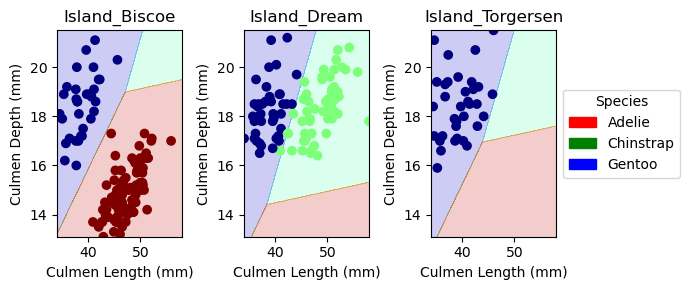

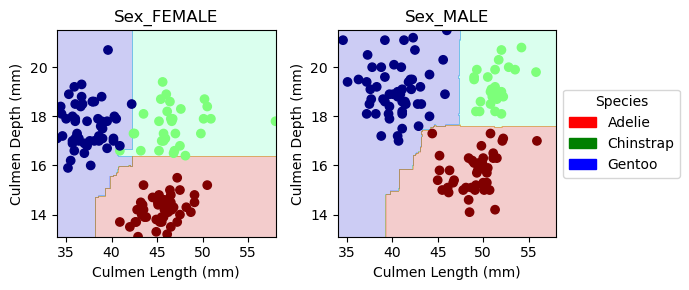

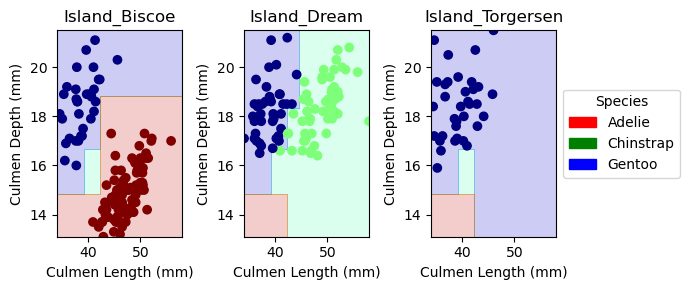

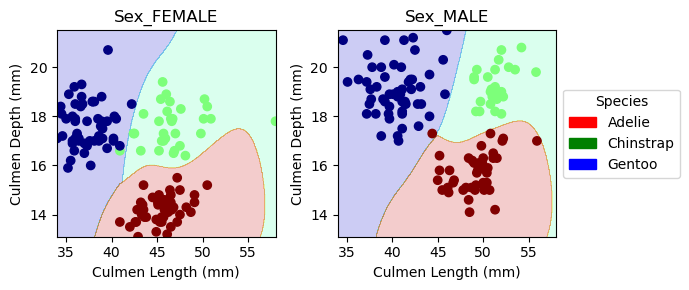

In [67]:
#| code-fold: true
#| fig-cap: Decision regions for logistic regression, RFC, DTC, and SVM.
#| fig-subcap:
#|  - Logistic Regression
#|  - Random Forest
#|  - Decision Tree
#|  - Support Vector Machine
#| layout-ncol: 2
#| label: fig-decision

plot_regions(LR, X_train[cols_LR], y_train)
plot_regions(RFC, X_train[cols_RFC], y_train)
plot_regions(DTC, X_train[cols_DTC], y_train)
plot_regions(SVM, X_train[cols_SVM], y_train)

From these plots, we can see that the RFC, DTC, and SVM models are potentially overfitting on the training data. As a result, we will use the logistic regression model for the testing data.

## Testing
With our models trained, we can now test the logistic regression model on the test data pulled from [here](https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv).

In [68]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test['Species'] = test['Species'].str.split().str.get(0)
X_test, y_test = prepare_data(test)


### Testing Score

In [69]:
LR.score(X_test[cols_LR], y_test)

1.0

Logistic regression has a test score of **100%** so we have accomplished our objective!



### Decision Regions

Now, let's look at the decision regions of the logistic regression model for the test data.

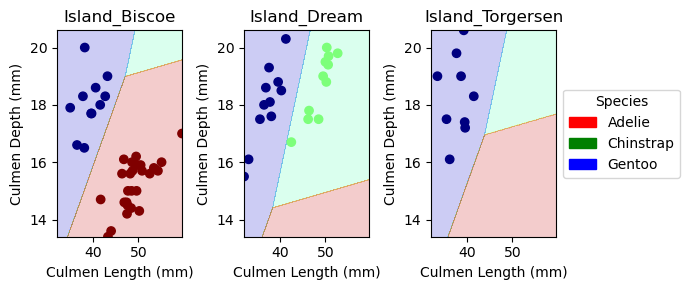

In [70]:
#| code-fold: true
#| fig-cap: Decision regions of the logistic regression model for the test data.
#| label: fig-test-decision
plot_regions(LR, X_test[cols_LR], y_test)

## Discussion

This study experiemented with `scikit-learn's` logistic regression, random forest classifier, decision tree classifier, and support vector machine models to predict penguin species from the Palmer Penguins data set with 100% testing accuracy. After training the four models, the random forest and decision tree classifiers had a training accuracy of 100%, while the logistic regression and support vector machine models had a training accuracy of 99.6% an 99.2% respectively. However, when looking at the decision regions in @fig-decision, we can see that the random forest and decision tree classifers and the support vector machine were potentially overfitting on the training data. As a result, I used the logistic regression model for the testing data and it successfully predicted the penguins' species with 100% testing accuracy.